In [2]:
!pip install tf-nightly-2.0-preview

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


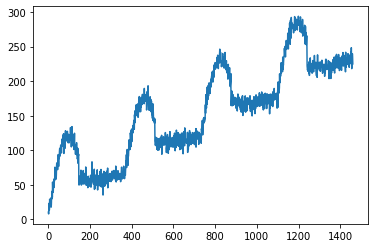

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.sin(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time1 = np.arange(4 * 365 + 1, dtype="float32")
baseline = 7
series1 = trend(time1, 0.001)  
baseline = 7
amplitude = 100
slope = 0.15
noise_level = 7

# Create the series
series1 = baseline + trend(time1, slope) + seasonality(time1, period=365, amplitude=amplitude)
# Update with noise
series1 += noise(time1, noise_level, seed=42)

split_time = 1000
time_train1 = time1[:split_time]
x_train1 = series1[:split_time]
time_valid1 = time1[split_time:]
x_valid1 = series1[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.plot(series1)

In [5]:
# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#   series = tf.expand_dims(series, axis=-1)
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
#   dataset = dataset.batch(batch_size).prefetch(1)
#   return dataset

def windowed_dataset(series1, window_size, batch_size, shuffle_buffer):
    series1 = tf.expand_dims(series1, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series1)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train1, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 21s 3s/step - loss: 160.8787 - mae: 161.2814
Epoch 2/100
8/8 [==============================] - 3s 313ms/step - loss: 159.7959 - mae: 160.2645
Epoch 3/100
8/8 [==============================] - 2s 197ms/step - loss: 158.1891 - mae: 158.6573
Epoch 4/100
8/8 [==============================] - 3s 389ms/step - loss: 155.9608 - mae: 156.6851
Epoch 5/100
8/8 [==============================] - 2s 189ms/step - loss: 154.0862 - mae: 154.4296
Epoch 6/100
8/8 [==============================] - 2s 307ms/step - loss: 151.6607 - mae: 151.9173
Epoch 7/100
8/8 [==============================] - 2s 232ms/step - loss: 148.5379 - mae: 149.1413
Epoch 8/100
8/8 [==============================] - 4s 463ms/step - loss: 145.1237 - mae: 146.0589
Epoch 9/100
8/8 [==============================] - 3s 436ms/step - loss: 142.1372 - mae: 142.6255
Epoch 10/100
8/8 [==============================] - 3s 423ms/step - loss: 138.1286 - mae: 138.7075
Epoch 11/100
8/8 [===

[1e-08, 0.0001, 0, 30]

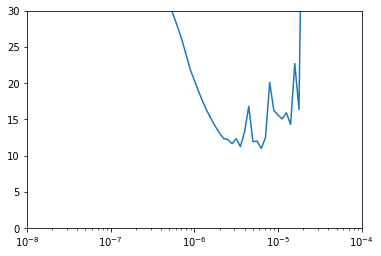

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
window_size = 20
dataset = windowed_dataset(x_train1, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=200)

Epoch 1/200
31/31 [==============================] - 4s 114ms/step - loss: 67.7559 - mae: 68.4957
Epoch 2/200
31/31 [==============================] - 1s 34ms/step - loss: 37.6867 - mae: 38.2081
Epoch 3/200
31/31 [==============================] - 1s 37ms/step - loss: 26.2326 - mae: 26.7610
Epoch 4/200
31/31 [==============================] - 1s 37ms/step - loss: 21.7942 - mae: 22.3283
Epoch 5/200
31/31 [==============================] - 1s 39ms/step - loss: 19.6748 - mae: 20.1245
Epoch 6/200
31/31 [==============================] - 1s 42ms/step - loss: 19.3580 - mae: 19.8154
Epoch 7/200
31/31 [==============================] - 1s 36ms/step - loss: 19.0360 - mae: 19.5274
Epoch 8/200
31/31 [==============================] - 1s 37ms/step - loss: 17.4063 - mae: 17.9335
Epoch 9/200
31/31 [==============================] - 1s 41ms/step - loss: 16.0955 - mae: 16.5657
Epoch 10/200
31/31 [==============================] - 1s 38ms/step - loss: 15.1351 - mae: 15.6043
Epoch 11/200
31/31 [========

31/31 [==============================] - 1s 38ms/step - loss: 6.7352 - mae: 7.2193
Epoch 170/200
31/31 [==============================] - 1s 47ms/step - loss: 7.2981 - mae: 7.7835
Epoch 171/200
31/31 [==============================] - 1s 39ms/step - loss: 6.6385 - mae: 7.1241
Epoch 172/200
31/31 [==============================] - 1s 34ms/step - loss: 6.8609 - mae: 7.3426
Epoch 173/200
31/31 [==============================] - 1s 38ms/step - loss: 6.9431 - mae: 7.4249
Epoch 174/200
31/31 [==============================] - 1s 37ms/step - loss: 6.7909 - mae: 7.2781
Epoch 175/200
31/31 [==============================] - 1s 39ms/step - loss: 6.7247 - mae: 7.2121
Epoch 176/200
31/31 [==============================] - 1s 38ms/step - loss: 6.8320 - mae: 7.3069
Epoch 177/200
31/31 [==============================] - 1s 38ms/step - loss: 6.6740 - mae: 7.1589
Epoch 178/200
31/31 [==============================] - 1s 33ms/step - loss: 6.5816 - mae: 7.0687
Epoch 179/200
31/31 [=======================

In [11]:
model.save("x_train2_tuning.h5")
print("Saved model to disk")

Saved model to disk


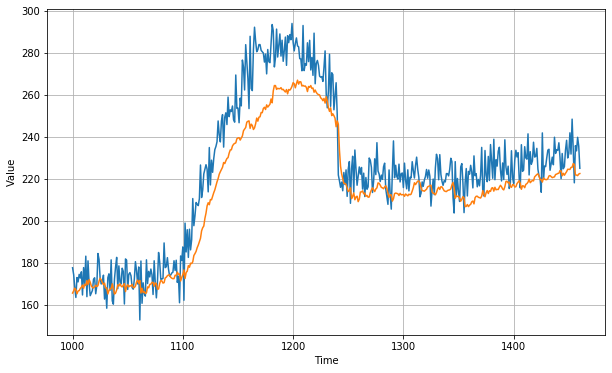

In [13]:
# forecast=[]
# for time in range(len(series) - window_size):
#   forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# forecast = forecast[split_time-window_size:]
# results = np.array(forecast)[:, 0, 0]


# plt.figure(figsize=(10, 6))

# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast1 = model_forecast(model, series1[..., np.newaxis], window_size)
rnn_forecast1 = rnn_forecast1[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid1, x_valid1)
plot_series(time_valid1, rnn_forecast1)



In [2]:
x_valid1

NameError: name 'x_valid1' is not defined

In [1]:
temp = x_valid1/3

NameError: name 'x_valid1' is not defined